/home/pkarpov/.conda/envs/torch/lib/python3.7/site-packages/skimage/util/shape.py:93: RuntimeWarning:

Cannot provide views on a non-contiguous input array without copying.



<IPython.core.display.Javascript object>

[2020-04-24 14:30:57,400] 
0/1 * Epoch 0 (train): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=20.3113 | _timers/batch_time=0.1969 | _timers/data_time=0.1189 | _timers/model_time=0.0778 | loss=0.0110
0/1 * Epoch 0 (valid): _base/lr=0.0010 | _base/momentum=0.9000 | _timers/_fps=22.2438 | _timers/batch_time=0.1798 | _timers/data_time=0.1405 | _timers/model_time=0.0392 | loss=0.0107
Top best models:
logs/checkpoints//train.0.pth	0.0107


../sapsan/utils/plot.py:23: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



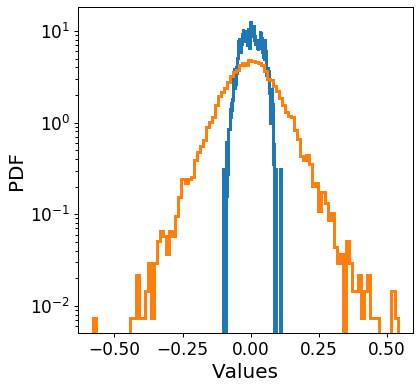

<Figure size 432x432 with 0 Axes>

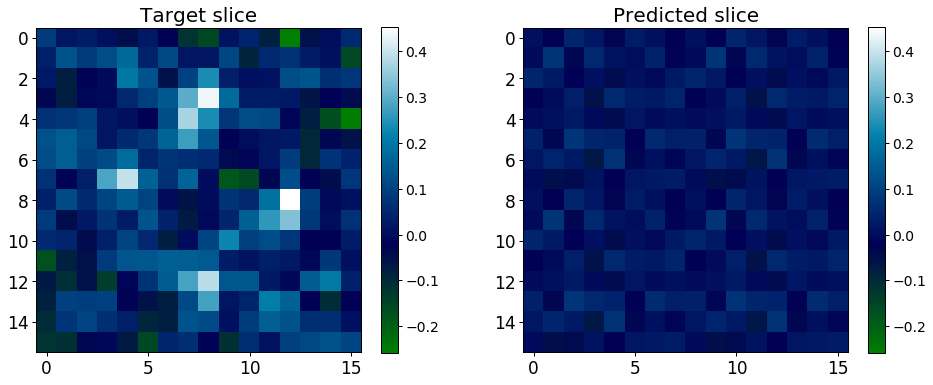

In [4]:
%matplotlib inline
import os
import sys
sys.path.append('../')

from sapsan.lib.backends.fake import FakeExperimentBackend
from sapsan.lib.data.jhtdb_dataset import JHTDB128Dataset
from sapsan.lib.data import Equidistance3dSampling
from sapsan.lib.estimator import Spacial3dEncoderNetworkEstimator, Spacial3dEncoderNetworkEstimatorConfiguration
from sapsan.lib.experiments.evaluation_3d import Evaluation3dExperiment
from sapsan.lib.experiments.training import TrainingExperiment

os.environ["AWS_ACCESS_KEY_ID"] = "<AWS_ACCESS_KEY_ID>"
os.environ["AWS_SECRET_ACCESS_KEY"] = "<AWS_SECRET_ACCESS_KEY>"

def run():
    MLFLOW_BACKEND_HOST = "0.0.0.0"
    MLFLOW_BACKEND_PORT = 9000
    path = "data/{feature}_dim32_fm15.h5"
    CHECKPOINT_DATA_SIZE = 32
    SAMPLE_TO = 16
    GRID_SIZE = 8
    features = ['u']
    target = ['u']

    sampler = Equidistance3dSampling(CHECKPOINT_DATA_SIZE, SAMPLE_TO)

    experiment_name = "CNN experiment"

    estimator = Spacial3dEncoderNetworkEstimator(
        config=Spacial3dEncoderNetworkEstimatorConfiguration(n_epochs=1, grid_dim=GRID_SIZE)
    )

    tracking_backend = FakeExperimentBackend(experiment_name)
    # tracking_backend = MlFlowExperimentBackend(experiment_name, MLFLOW_BACKEND_HOST, MLFLOW_BACKEND_PORT)

    x, y = JHTDB128Dataset(path=path,
                           features=features,
                           target=target,
                           checkpoints=[0],
                           grid_size=GRID_SIZE,
                           checkpoint_data_size=CHECKPOINT_DATA_SIZE,
                           sampler=sampler).load()

    training_experiment = TrainingExperiment(name=experiment_name,
                                             backend=tracking_backend,
                                             model=estimator,
                                             inputs=x, targets=y)
    training_experiment.run()

    x, y = JHTDB128Dataset(path=path,
                           features=features,
                           target=target,
                           checkpoints=[0],
                           grid_size=GRID_SIZE,
                           checkpoint_data_size=CHECKPOINT_DATA_SIZE,
                           sampler=sampler).load()

    evaluation_experiment = Evaluation3dExperiment(name=experiment_name,
                                                   backend=tracking_backend,
                                                   model=training_experiment.model,
                                                   inputs=x, targets=y,
                                                   grid_size=GRID_SIZE,
                                                   checkpoint_data_size=SAMPLE_TO)

    evaluation_experiment.run()


if __name__ == '__main__':
    run()